In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

Use one unit length to represent 100nm, so one unit frequency = 1/(100nm) => c/(100nm)=3000 THz. Conversely, if $\omega=x$THz, this corresponding to the frequency $f= x/1000/(6\pi)$ units.

Here we set the frequency range of the source from $250$THz to $1250$THz and divide this range to 1000(nfreq) segments. The 'dfp' parameter control how much of this range that we want the flux detector to monitor.

In [128]:
start_plot = True
frq_min = 0.25/(6*np.pi)
frq_max = 1.25/(6*np.pi)
wvl_max = 1/frq_min
wvl_min = 1/frq_max
nfreq = 1000
fcen = (frq_min + frq_max)/2
df = frq_max - frq_min
dfp = 1/2

In the following, we setup the several parameters of the simulation including the paramters of the two layers. 

The simulation is one dimensional so the boundary is at the left and right ends. The boundary is choosen as PML to absorpt all of the incoming waves without reflecting and the width of the PML is choosen to be more than 1/2 of the longest wavelength in the wave. The size of the cell to do the simulation (sz) is choosen to be 4 times the thickness of the PML plus the size of the geometry.

The resolution is set at 100 which should be more than enough considering the frequency range of the source and the size of the geometry.

The position of the source and the flux detector is set by source_z and flux_reg respectively.

In [129]:
dpml = np.floor(0.5*wvl_max)+1

dA = 2
dB = 3
epsilonA = 12
epsilonB = 3

NAB = 1

sz = 4*dpml+(dA+dB)*NAB

resolution = 100 # pixels/μm

freg_p = 0.1
cell_size = mp.Vector3(z=sz)

pml_layers = [mp.PML(thickness=dpml)]

source_z=-sz/2+dpml
flux_reg_z=sz/2-dpml

Here, we define two functions to make adding the two layers of the geometries more conveniently. 

In [130]:
def BlockAB(N, center):
    geometry = []
    for i in range(N):
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA/2),
                     material=mp.Medium(epsilon=epsilonA)))
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dA + dB/2),
                     material=mp.Medium(epsilon=epsilonB)))
    geometry = geometry.tolist()
    return geometry

In [131]:
def BlockBA(N, center):
    geometry = []
    for i in range(N):
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dB),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dB/2),
                     material=mp.Medium(epsilon=epsilonB)))
        geometry = np.append(geometry, mp.Block(mp.Vector3(mp.inf,mp.inf,dA),
                     center=mp.Vector3(z=center-(dA+dB)*N/2 + (dA+dB)*i + dB + dA/2),
                     material=mp.Medium(epsilon=epsilonA)))
    geometry = geometry.tolist()
    return geometry

Here, we choose the source to be GaussianSource and set the range of the frquency and the position.

In [132]:
sources = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                     component=mp.Ex,
                     center=mp.Vector3(z=source_z),
                     size=mp.Vector3())]

First, we define a vacuum simulation without the geometries. We use "FluxRegeion" to define the region where the flux is monitored and use add_flux to add up all the flux through this region.

In [133]:
sim_vac = mp.Simulation(cell_size=cell_size,
                    resolution=resolution,
                    boundary_layers=pml_layers,
                    dimensions=1,
                    sources=sources)
tran_fr = mp.FluxRegion(center=mp.Vector3(z=flux_reg_z))
tran = sim_vac.add_flux(fcen, df*dfp, nfreq, tran_fr)

Then, we run the simulation in vaccum in order to get the reference flux. The simulation run until the field decay to 1/1000 at some point. It is unclear that how to setup the position of this point appropriately. Here, we set the point at the same position of the flux region. But, in the official meep examples, they set this point before the region.

In [134]:
pt = mp.Vector3(z=flux_reg_z)
sim_vac.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ex,mp.Vector3(z=0),1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 0.00250983 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 157 with resolution 100
time for set_epsilon = 0.0177429 s
-----------
field decay(t = 50.005): 7.957636837758343e-10 / 7.957636837758343e-10 = 1.0
field decay(t = 100.01): 0.008412536735237598 / 0.008412536735237598 = 1.0
field decay(t = 150.01500000000001): 0.2500004117359742 / 0.2500004117359742 = 1.0
field decay(t = 200.02): 0.05848705938590039 / 0.2500004117359742 = 0.23394785224461412
field decay(t = 250.025): 2.5092770949987e-07 / 0.2500004117359742 = 1.0037091849467638e-06
run 0 finished at t = 250.025 (50005 timesteps)


---
After the simulation, we can obtain a list of the frequencies and the corresponding flux.

In [135]:
vac_flux = mp.get_fluxes(tran)
flux_freqs = mp.get_flux_freqs(tran)

Then, we can define actual simulaiton containing the geometries. The parts that define the flux region and adding flux are the same.

In [136]:
sim = mp.Simulation(cell_size=cell_size,
                    resolution=resolution,
                    boundary_layers=pml_layers,
                    sources=sources,
                    dimensions=1,
                    geometry=BlockAB(NAB,0))
tran_fr = mp.FluxRegion(center=mp.Vector3(z=flux_reg_z))
tran = sim.add_flux(fcen, df*dfp, nfreq, tran_fr)

Now, we can do an actual simulation with the geometries.

In [137]:
pt = mp.Vector3(z=flux_reg_z)

sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ex,mp.Vector3(z=0),1e-3))

-----------
Initializing structure...
time for choose_chunkdivision = 0.00229406 s
Working in 1D dimensions.
Computational cell is 0 x 0 x 157 with resolution 100
     block, center = (0,0,-1.5)
          size (1e+20,1e+20,2)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12,12,12)
     block, center = (0,0,1)
          size (1e+20,1e+20,3)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3,3,3)
time for set_epsilon = 0.0237551 s
-----------
field decay(t = 50.005): 2.2684848748117025e-12 / 2.2684848748117025e-12 = 1.0
field decay(t = 100.01): 0.00025088782800192656 / 0.00025088782800192656 = 1.0
field decay(t = 150.01500000000001): 0.06742661912897592 / 0.06742661912897592 = 1.0
field decay(t = 200.02): 0.044117900901471385 / 0.06742661912897592 = 0.6543098478225813
field decay(t = 250.025): 4.703221092811522e-05 / 0.06742661912897592 = 0.0006975317988011592
run 0 finished at t = 250.025 (50005 times

---
If we want to patch the graph with several ranges of the frequency, we can set "start_plot" to false in order to do the next part of the range.

In [138]:
if start_plot:
    wl=[]
    Ts=[]

Here, we make a list of $T$ vs $\omega$ in order to plot them.

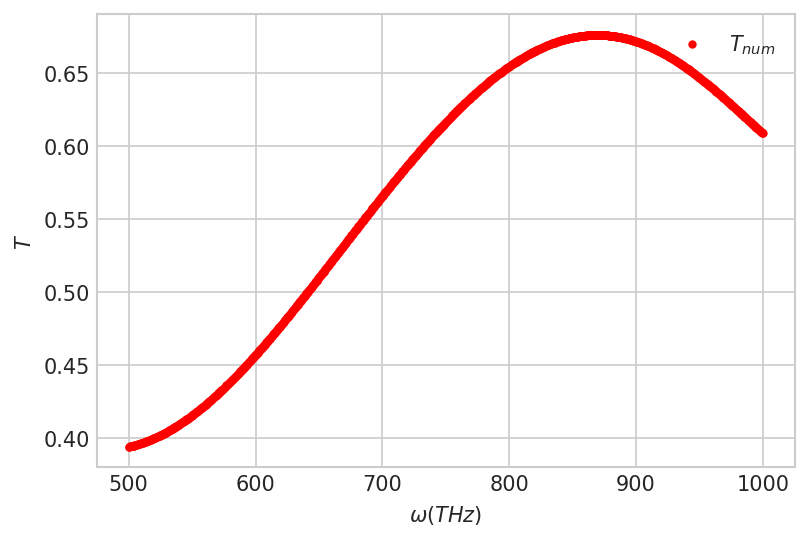

In [139]:
tran_flux = mp.get_fluxes(tran)

for i in range(nfreq):
    wl = np.append(wl, 2*flux_freqs[i]*np.pi*3*10**3)
    Ts = np.append(Ts,tran_flux[i]/vac_flux[i])    

if mp.am_master():
    plt.figure(dpi=150)
    plt.style.use('seaborn-whitegrid')
    plt.plot(wl,Ts,'r.',label='$T_{num}$')
    plt.xlabel(r'$\omega(THz)$')
    plt.ylabel('$T$')
    plt.legend(loc="upper right")
    plt.savefig('Tasks_2_2(500-1000).png')
    plt.show()    